In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import svm, model_selection
from sklearn.model_selection import KFold

# this one is only needed if you want to use dictionary in getOptimalSMV
import operator

# use seaborn plotting defaults
import seaborn as sns 
sns.set()
#Load Dataset
data = np.loadtxt('dataSVM.txt')

#what kernel to use for the SVM
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svcKernel = 'linear'

#what gamma to use 
svcGamma = 'scale'
"""
    if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,

    if ‘auto’, uses 1 / n_features.
"""


#Getting first 0.8 of dataset
#Training set
features = data[0:int(len(data) * 0.8), :-1]
labels = data[0:int(len(data) * 0.8), 2]
#Getting last 0.2 of dataset
#Testing set
testingFeatures = data[int(len(data) * 0.8):, :]
testingLabels = data[int(len(data) * 0.8):, 2]

print(features.shape)
print(labels.shape)
print(testingFeatures.shape)
print(testingLabels.shape)

(800, 2)
(800,)
(200, 3)
(200,)


In [32]:
# the function aims to visualize the input data X, colored according to labels Y, 
# superimposed over the decision boundary of the classifier clf
def plot_decision_boundary(clf, X, Y, cmap='Paired_r'):
    h = 0.02
    
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Assign the figure to var fig so we can save it later
    fig = plt.figure(figsize=(20,10))
    
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k')

    #Labels and title of plot
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.title("Plot of the two features ")
  
    plt.show()
    return fig


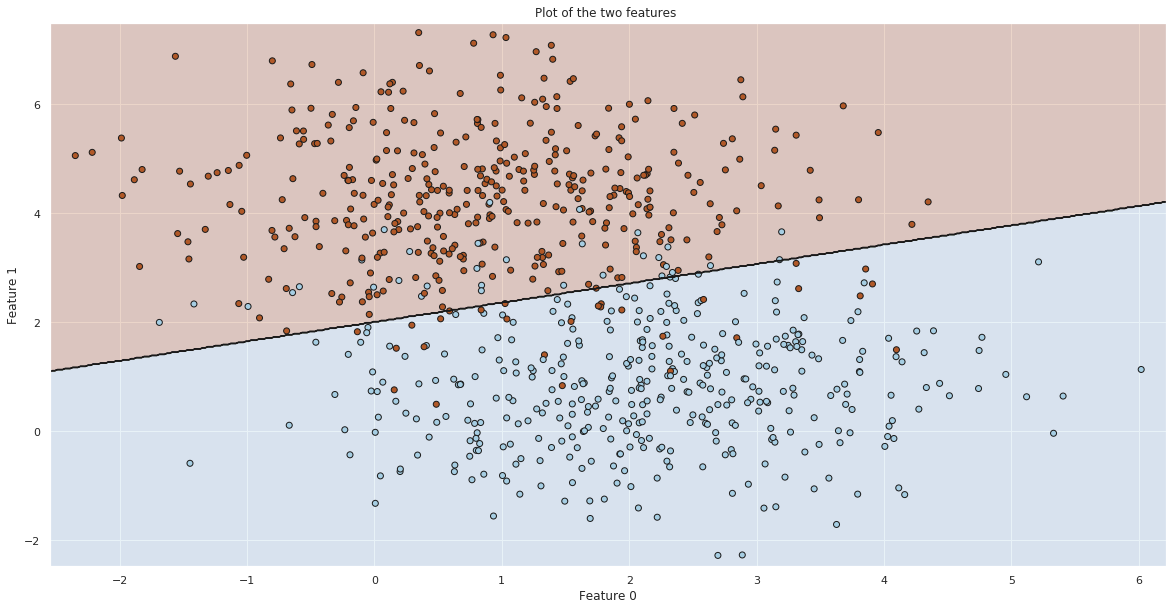

<function matplotlib.pyplot.close(fig=None)>

In [36]:
clf = svm.SVC(kernel = svcKernel, C = 10, gamma=svcGamma)
clf.fit(features, labels)
figure = plot_decision_boundary(clf, features, labels)
figure.savefig("plot-"+str(clf)+".png")
plt.close()

In [37]:
class CrossValidation_SVM:
    
    def __init__(self, n_folds = 5, parameterCList = [0.001, 0.01, 0.1, 1, 10, 100]):
        """
        Initializes the model.
        
        Parameters
        ----------
        n_folds : the number of folds we expect to use for cross-validation
        """
        
        self.n_folds = n_folds
        self.parameterCList = parameterCList
    
    def __generateNextSplit(self, features, labels, kfold):
        """
        Use this function to generate next split of the input features and labels into 
        training and validation parts
        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        kfold    : iterator
        
        N is the number of samples, M is the number of features
        
        Returns
        -------
        trainingFeatures   : subportion of the features selected for training using the surrent split
        trainingLabels     : subportion of the labels selected for training using the surrent split
        validationFeatures : subportion of the features selected for validation using the surrent split
        validationLabels   : subportion of the labels selected for validation using the surrent split
        """ 
        
        train_index, validation_index = next(kfold.split(features))
        return features[train_index, :], labels[train_index], \
               features[validation_index, :], labels[validation_index], \
        #return trainingFeatures, trainingLabels, validationFeatures, validationLabels
    
    def __computeErrorForSpecificC(self, features, labels, C):
        """
        Iterate throught all splits and compute the SVM performance using the specified C.
        Use linear kernel for svm.

        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        C : svm regularization parameter
        
        Returns
        -------
        meanAccuracy : mean validation accuracy computer over all splits
        """         
        
        accuracyArray = []
        
        # this function should use __generateNextSplit for iterating over splits
        
        # The iterator over folds. If you don't want to use it, feel free to implement your own iterator
        kfold = KFold(self.n_folds, shuffle = False)
        for i in range(0, self.n_folds):
            trainingFeatures, trainingLabels, validationFeatures, validationLabels = \
                    self.__generateNextSplit(features, labels, kfold)
            #https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
            clf = svm.SVC(kernel = svcKernel, C = C, gamma = svcGamma)
            clf.fit(trainingFeatures, trainingLabels)
            results = clf.predict(validationFeatures)
            accuracyArray.append(np.mean(results == validationLabels))
        
        return np.mean(accuracyArray)
    
    def getOptimalSMV(self, features, labels):
        """
        Iterate throught all C from self.parameterCList to find the optimal one

        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        Returns
        -------
        clf : the optimal SVM classfier trained on all input features and label
        accuracyList : the list of mean accuracies for each C from self.parameterCList.
                       accuracyList should be of the length len(self.parameterCList) 
        """
        
        accuracyList = {}# can use dictionary here: accuracyDict = {}
        for C in self.parameterCList:
            #go through all C in self.parameterCList using __computeErrorForSpecificC
            #save mean accuracyies in accuracyList for all C's
            accuracyList[C] = self.__computeErrorForSpecificC(features, labels, C)
        
        #using dictionary
        #finding the C with the highest mean accuracy using max
        optC = max(accuracyList.items(), key=operator.itemgetter(1))[0]
        
        #linear kernel options are {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
        #train clf on all input features and label using the optimal C
        clf = svm.SVC(kernel = svcKernel, C = optC, gamma = svcGamma)
        
        clf.fit(features, labels)
        return clf, accuracyList
        

{1e-05: 0.46875, 0.001: 0.925, 0.01: 0.925, 0.1: 0.93125, 1: 0.925, 10: 0.925, 100: 0.925}
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


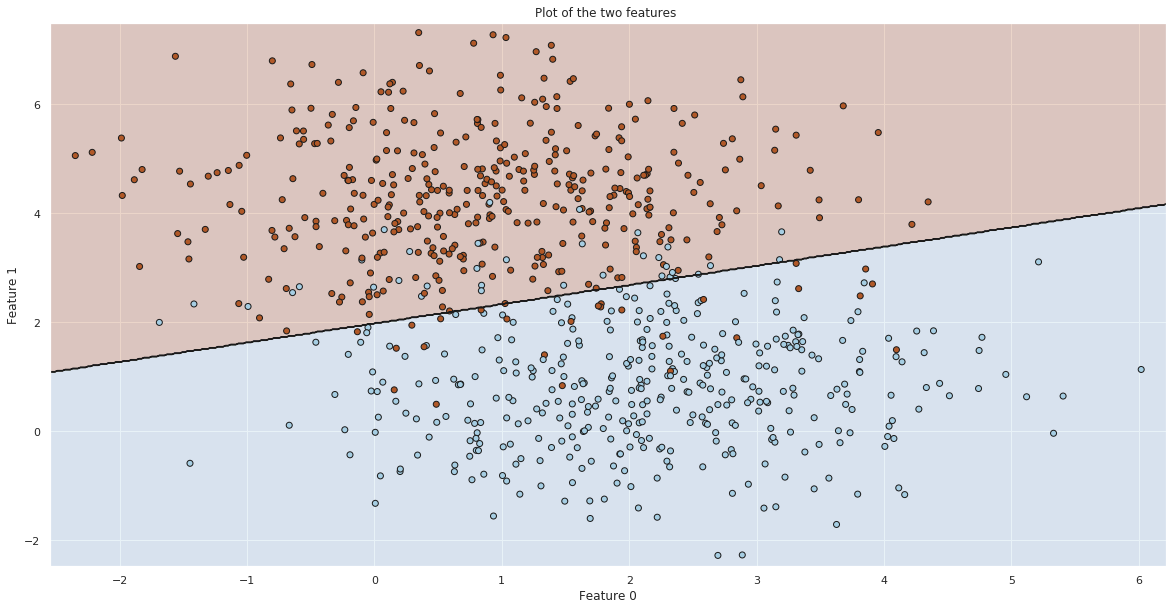

In [39]:
#this is the code to test your cross-validation implementation.
n_folds = 5
# parameterClist = basic error measure underlying the cross-validation error
# Create an instance of crossvalidation of the svm
tester = CrossValidation_SVM(n_folds = n_folds, parameterCList = [0.00001, 0.001, 0.01, 0.1, 1, 10, 100])
#Extract the clf and accuracies for 
clf, accuracyList = tester.getOptimalSMV(features, labels)
print(accuracyList)
print(clf)
clf.fit(features,labels)
#the maximal margin/boundary between the two classes
figure = plot_decision_boundary(clf, features, labels)
figure.savefig("plot-"+str(clf)+".png")
plt.close()